In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.neighbors
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
!pip install gensim
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import random
import plotly.express as px

In [2]:
##Importing File
from google.colab import drive
drive.mount('google_drive')

Mounted at google_drive


In [5]:
filepath = '/content/google_drive/MyDrive/Tweets.csv'
df = pd.read_csv(filepath)

In [6]:
df.head()
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

EDA

In [7]:
print(df.describe())

           tweet_id  airline_sentiment_confidence  negativereason_confidence  \
count  1.464000e+04                  14640.000000               10522.000000   
mean   5.692184e+17                      0.900169                   0.638298   
std    7.791112e+14                      0.162830                   0.330440   
min    5.675883e+17                      0.335000                   0.000000   
25%    5.685592e+17                      0.692300                   0.360600   
50%    5.694779e+17                      1.000000                   0.670600   
75%    5.698905e+17                      1.000000                   1.000000   
max    5.703106e+17                      1.000000                   1.000000   

       retweet_count  
count   14640.000000  
mean        0.082650  
std         0.745778  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        44.000000  


In [8]:
df.rename(columns={
    "airline_sentiment": "sentiment",
    "airline_sentiment_confidence": "sentiment_conf",
    "negativereason": "neg_reason",
    "negativereason_confidence": "neg_reason_conf",
    "airline_sentiment_gold": "sentiment_gold",
    "negativereason_gold": "neg_reason_gold",
    "retweet_count": "retweets",
    "text": "tweet_text",
    "tweet_coord": "coordinates",
    "tweet_created": "timestamp",
    "tweet_location": "tweet_loc",
    "user_timezone": "timezone",
    "name": "user_name"
}, inplace=True)


In [9]:
df["sentiment"].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

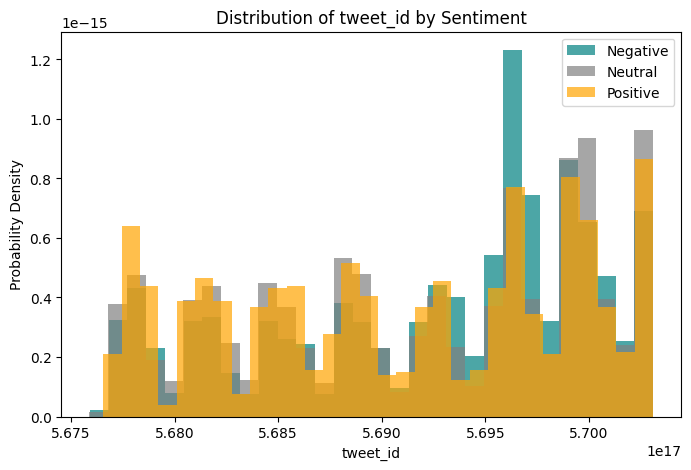

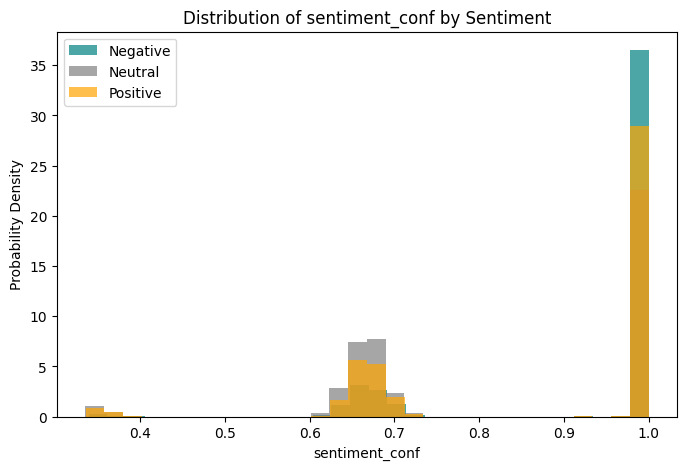

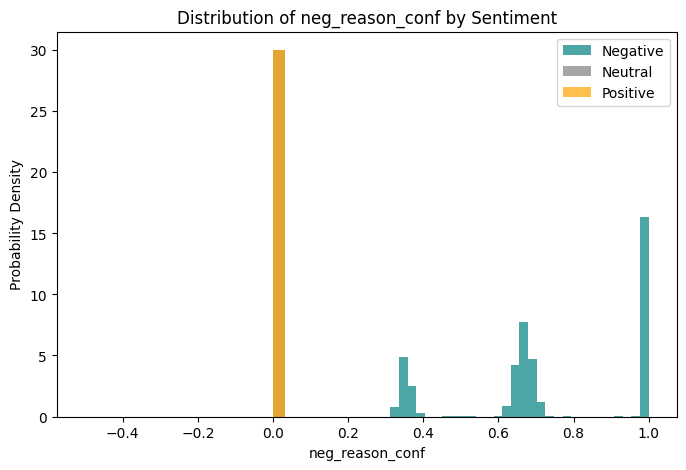

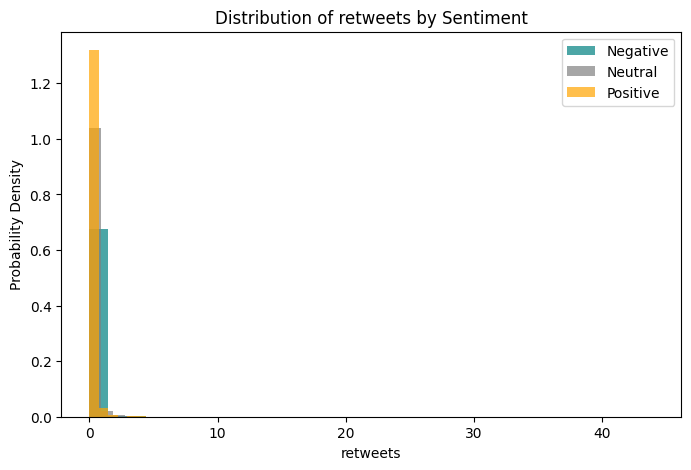

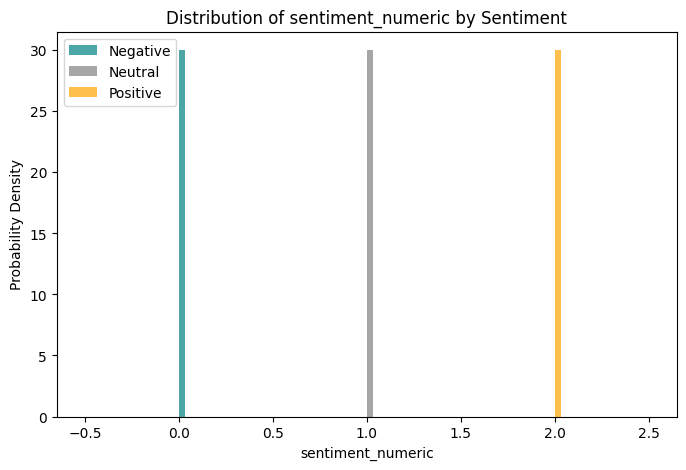

In [10]:
# Convert categorical sentiments to numerical values
df["sentiment_numeric"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Select only numeric columns for plotting
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for label in numeric_cols:
    plt.figure(figsize=(8, 5))

    plt.hist(df[df["sentiment_numeric"] == 0][label], bins=30, color='teal', label='Negative', alpha=0.7, density=True)
    plt.hist(df[df["sentiment_numeric"] == 1][label], bins=30, color='grey', label='Neutral', alpha=0.7, density=True)
    plt.hist(df[df["sentiment_numeric"] == 2][label], bins=30, color='orange', label='Positive', alpha=0.7, density=True)

    plt.title(f"Distribution of {label} by Sentiment")
    plt.ylabel("Probability Density")
    plt.xlabel(label)
    plt.legend()
    plt.show()


In [11]:
print(df.isnull().sum())

tweet_id                 0
sentiment                0
sentiment_conf           0
neg_reason            5462
neg_reason_conf       4118
airline                  0
sentiment_gold       14600
user_name                0
neg_reason_gold      14608
retweets                 0
tweet_text               0
coordinates          13621
timestamp                0
tweet_loc             4733
timezone              4820
sentiment_numeric        0
dtype: int64


In [12]:
# Fill categorical missing values
df["neg_reason"].fillna("Unknown", inplace=True)
df["tweet_loc"].fillna("Unknown", inplace=True)
df["timezone"].fillna(df["timezone"].mode()[0], inplace=True)  # Fill with most common timezone

# Fill missing numeric confidence values with the median
df["neg_reason_conf"].fillna(df["neg_reason_conf"].median(), inplace=True)

# Drop unnecessary columns with too many missing values
df.drop(columns=["sentiment_gold", "neg_reason_gold", "coordinates"], inplace=True)

# Verify if missing values remain
print(df.isnull().sum())

tweet_id             0
sentiment            0
sentiment_conf       0
neg_reason           0
neg_reason_conf      0
airline              0
user_name            0
retweets             0
tweet_text           0
timestamp            0
tweet_loc            0
timezone             0
sentiment_numeric    0
dtype: int64


/tmp/ipython-input-3006227338.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["neg_reason"].fillna("Unknown", inplace=True)
/tmp/ipython-input-3006227338.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [13]:
# Download necessary NLTK data
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing punkt_tab data

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    return " ".join(cleaned_tokens)

# Apply function to the tweet text column
df["clean_tweet_text"] = df["tweet_text"].apply(clean_text)

# Display cleaned text
df[["tweet_text", "clean_tweet_text"]].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,tweet_text,clean_tweet_text
0,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercial expe...
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...
3,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


In [14]:
# Tokenize the text for Word2Vec
df["tokenized"] = df["clean_tweet_text"].apply(lambda x: x.split())

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=df["tokenized"], vector_size=100, window=5, min_count=2, workers=4)

# Get vector for a word
word_vector = w2v_model.wv["excellent"]
print(word_vector)


[-0.04278535  0.16897248  0.01333775  0.00503516  0.09682061 -0.3501177
  0.16432016  0.31418318 -0.11341067 -0.1583007  -0.1384266  -0.2766136
 -0.1906576   0.1925843   0.14515594 -0.05557164  0.01545617 -0.20084433
  0.05760637 -0.26738435  0.08168862  0.0636593   0.15747668 -0.17834209
  0.1554896  -0.06550281 -0.20284168 -0.22477396 -0.12367899  0.09607209
  0.2620131  -0.0134618   0.08779649 -0.13483438 -0.04160399  0.15109284
 -0.09730566 -0.06750774 -0.02999823 -0.24107717 -0.09185023 -0.23569544
 -0.11594947  0.04127899  0.04913009 -0.0096372  -0.1788095  -0.03824195
  0.08415796  0.12892929  0.06689384 -0.16730005 -0.04221454 -0.01864874
 -0.06612485  0.17582293  0.07573632  0.09503233 -0.21981113  0.16264117
 -0.10286013  0.113274   -0.1453181   0.00739357 -0.16496782  0.11968299
  0.1661608   0.05727598 -0.08894733  0.22972645 -0.15242156  0.01164799
  0.06435072 -0.06832842  0.22593032 -0.04039804 -0.03108391 -0.13411818
 -0.04251522 -0.02959105 -0.01390422 -0.04328245 -0.1

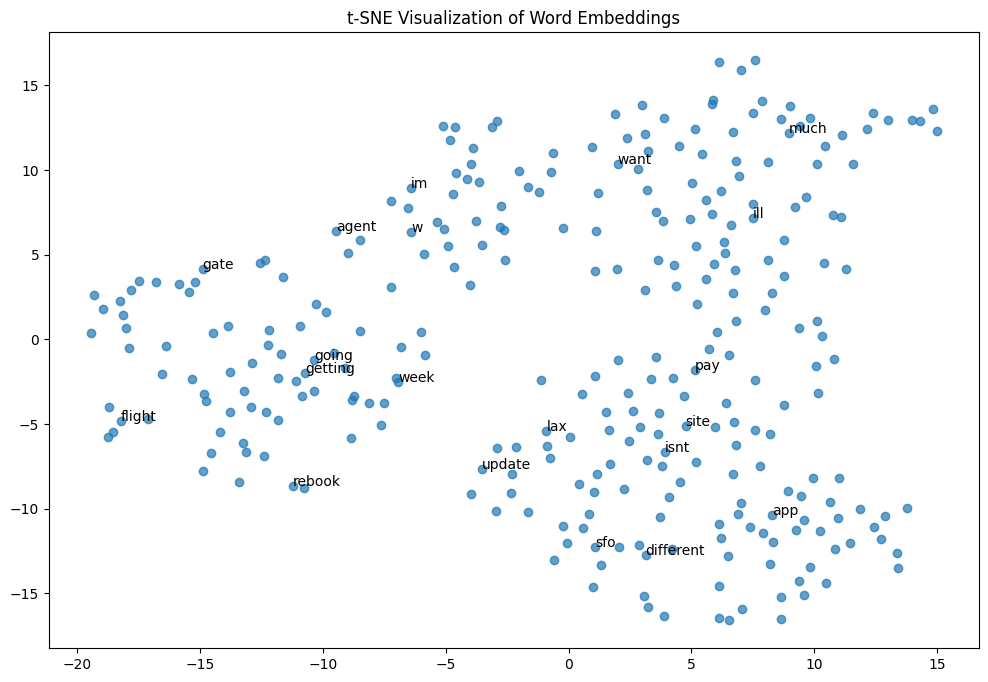

In [15]:
# Extract words and their vectors from Word2Vec model
word_vectors = np.array([w2v_model.wv[word] for word in w2v_model.wv.index_to_key])
words = list(w2v_model.wv.index_to_key)

# Reduce dimensions from 100D to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_2d = tsne.fit_transform(word_vectors[:300])  # Visualizing top 300 words

# Plot the words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

# Annotate some words in the plot
for i in range(0, 300, 15):  # Label every 15th word to reduce clutter
    plt.annotate(words[i], (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

#EDA

/tmp/ipython-input-1083263398.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", palette="coolwarm")


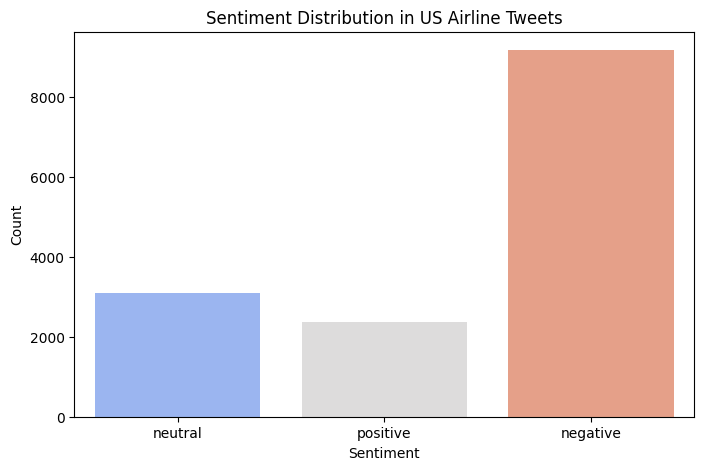

In [16]:
#Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution in US Airline Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

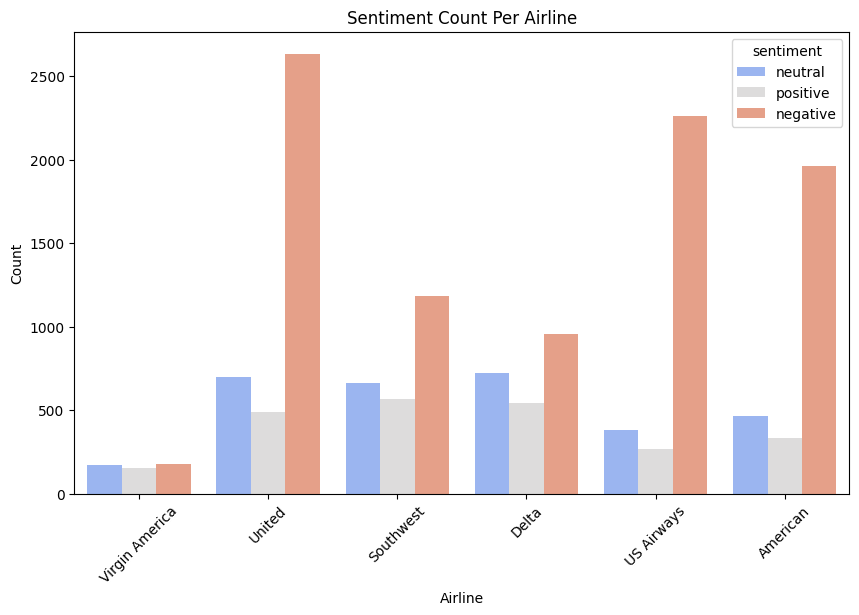

In [17]:
#Sentiment Analysis for Each Airline
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="airline", hue="sentiment", palette="coolwarm")
plt.title("Sentiment Count Per Airline")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-353909999.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["neg_reason"], order=df["neg_reason"].value_counts().index, palette="Reds_r")


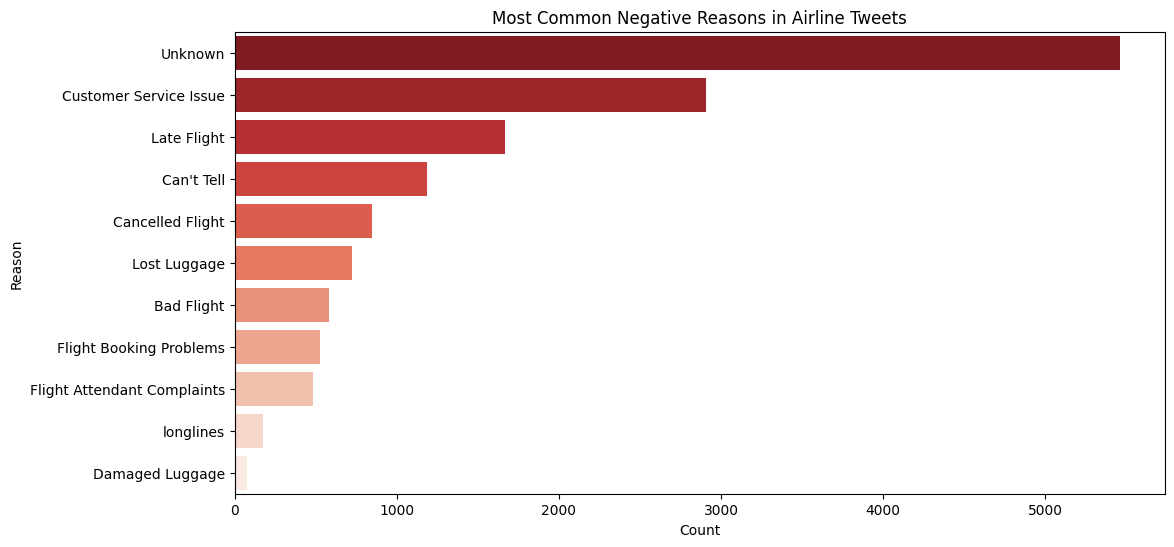

In [18]:
#Most common negative reasons
plt.figure(figsize=(12, 6))
sns.countplot(y=df["neg_reason"], order=df["neg_reason"].value_counts().index, palette="Reds_r")
plt.title("Most Common Negative Reasons in Airline Tweets")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.show()


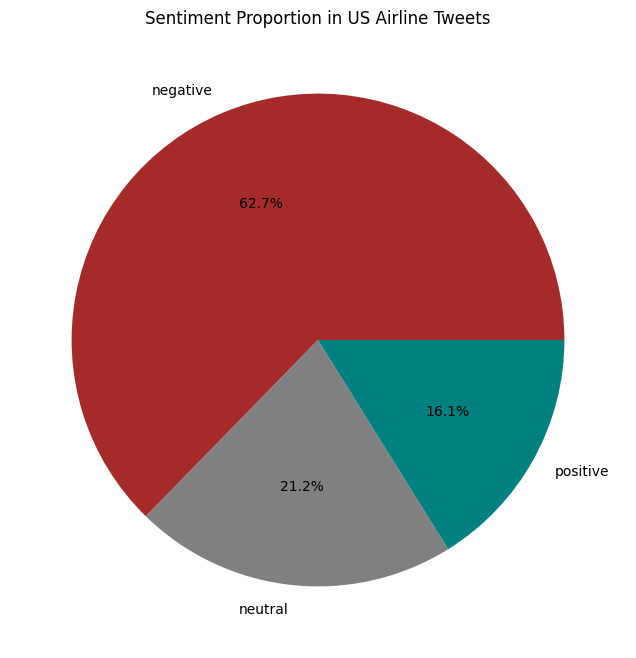

In [19]:
plt.figure(figsize=(8, 8))
df["sentiment"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["brown", "gray", "teal"])
plt.title("Sentiment Proportion in US Airline Tweets")
plt.ylabel("")  # Hide y-label
plt.show()


#**Machine Learning**

In [27]:
#Train, Validation, Test
# Extract features (X) and target (y)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_tweet_text"])
y = df["sentiment_numeric"]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [28]:
X_train_final = X_train
X_test_final = X_test


#KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

In [52]:
# --- KNN ---
print("===== KNN Classification Report =====")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_final, y_train)
y_pred_knn = knn_model.predict(X_test_final)
print(classification_report(y_test, y_pred_knn))

===== KNN Classification Report =====
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1835
           1       0.44      0.50      0.47       620
           2       0.68      0.51      0.58       473

    accuracy                           0.70      2928
   macro avg       0.64      0.61      0.62      2928
weighted avg       0.70      0.70      0.70      2928



#Logistic Regression

In [53]:
import sklearn.linear_model as linear_model

In [54]:
# --- Logistic Regression ---
print("===== Logistic Regression Report =====")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_final, y_train)
y_pred_logreg = log_reg.predict(X_test_final)
print(classification_report(y_test, y_pred_logreg))

===== Logistic Regression Report =====
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1835
           1       0.65      0.52      0.58       620
           2       0.80      0.56      0.66       473

    accuracy                           0.79      2928
   macro avg       0.76      0.67      0.71      2928
weighted avg       0.78      0.79      0.78      2928



#SVM

In [61]:
import sklearn.svm as svm

In [62]:
# --- SVM ---
print("===== SVM Report =====")
svm_model = svm.SVC()
svm_model.fit(X_train_final, y_train)
y_pred_svm = svm_model.predict(X_test_final)
print(classification_report(y_test, y_pred_svm))

===== SVM Report =====
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1835
           1       0.70      0.46      0.56       620
           2       0.83      0.55      0.66       473

    accuracy                           0.79      2928
   macro avg       0.78      0.66      0.70      2928
weighted avg       0.78      0.79      0.77      2928



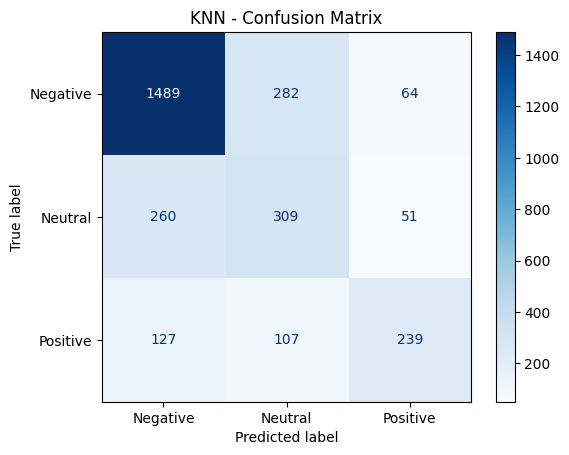

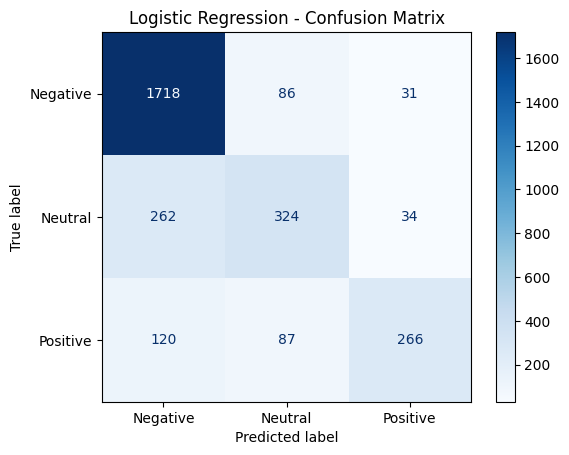

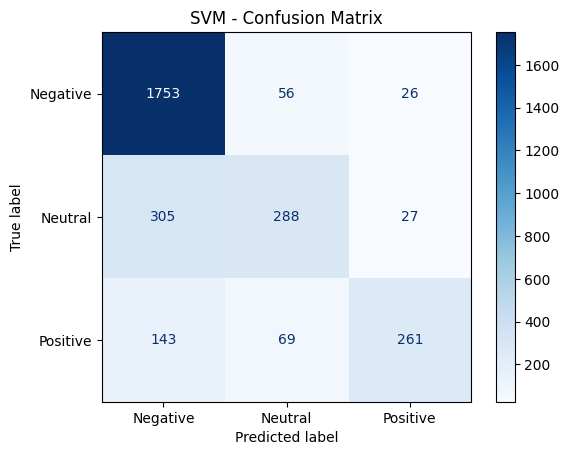

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

models = {
    "KNN": y_pred_knn,
    "Logistic Regression": y_pred_logreg,
    "SVM": y_pred_svm
}

for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


# **TUNE AND COMPARE MODELS**

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

results = {}

# --- KNN Tuning ---
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1_weighted')
knn_grid.fit(X_train_final, y_train)
knn_best = knn_grid.best_estimator_

y_pred_knn = knn_best.predict(X_test_final)
results["KNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "F1 Score": f1_score(y_test, y_pred_knn, average='weighted'),
    "Best Params": knn_grid.best_params_
}

In [66]:
# --- Logistic Regression Tuning ---
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, scoring='f1_weighted')
logreg_grid.fit(X_train_final, y_train)
logreg_best = logreg_grid.best_estimator_

y_pred_logreg = logreg_best.predict(X_test_final)
results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_logreg),
    "F1 Score": f1_score(y_test, y_pred_logreg, average='weighted'),
    "Best Params": logreg_grid.best_params_
}


In [68]:
from sklearn.svm import SVC

# --- SVM Tuning ---
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1_weighted')
svm_grid.fit(X_train_final, y_train)
svm_best = svm_grid.best_estimator_

y_pred_svm = svm_best.predict(X_test_final)
results["SVM"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "F1 Score": f1_score(y_test, y_pred_svm, average='weighted'),
    "Best Params": svm_grid.best_params_
}

In [69]:
import pandas as pd

# Converts results to DataFrame
results_df = pd.DataFrame(results).T  # Transpose for better view
results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)
results_df


,Model,Accuracy,F1 Score,Best Params
0,KNN,0.731216,0.725225,{'n_neighbors': 9}
1,Logistic Regression,0.788251,0.776967,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
2,SVM,0.791325,0.781831,"{'C': 10, 'kernel': 'rbf'}"


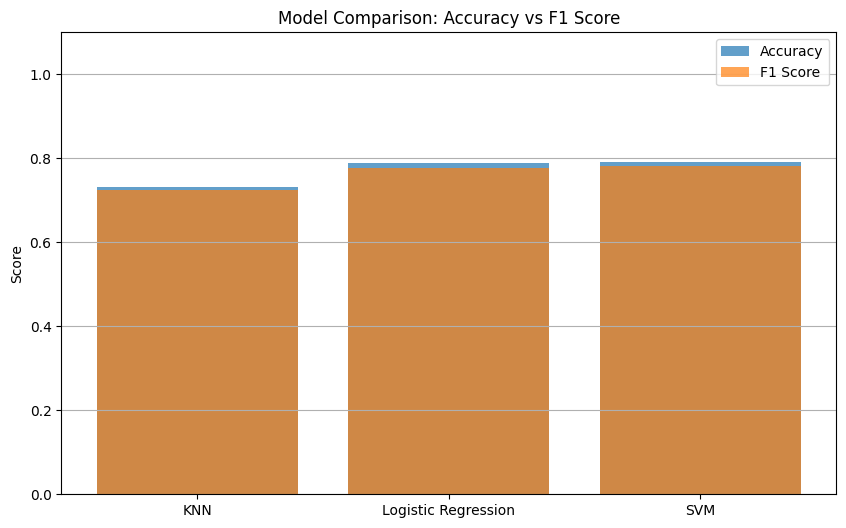

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = results_df["Model"]
accuracy = results_df["Accuracy"]
f1 = results_df["F1 Score"]

plt.bar(x, accuracy, label='Accuracy', alpha=0.7)
plt.bar(x, f1, label='F1 Score', alpha=0.7)
plt.ylim(0, 1.1)
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y')
plt.show()
